<a href="https://colab.research.google.com/github/worldisconfusion/Minor_Project/blob/main/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Modules**


In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [90]:
store_sales=pd.read_csv('train.csv')
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Checking for null values in the dataset.

In [91]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Since,we are only concerned about overall sales, we do not need storeid and item, so we can drop those.

In [92]:
store_sales=store_sales.drop(['store','item'],axis=1)

In [93]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


Converting date from object data-type to dateTime data-type.

In [94]:
store_sales['date']=pd.to_datetime(store_sales['date'])

In [95]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


Rather than predicting the sales on next day we would train the model to predict the sales in the period of next month which would be more intuitive.Converting date to a Month period, and then sum the number of items in each month

In [96]:
store_sales['date']=store_sales['date'].dt.to_period('M')
monthly_sales=store_sales.groupby('date').sum().reset_index()

Converting the resulting date column to timestamp datatype

In [97]:
monthly_sales['date']=monthly_sales['date'].dt.to_timestamp()

In [98]:
monthly_sales.head(5)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


In [99]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    60 non-null     datetime64[ns]
 1   sales   60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


Visualization

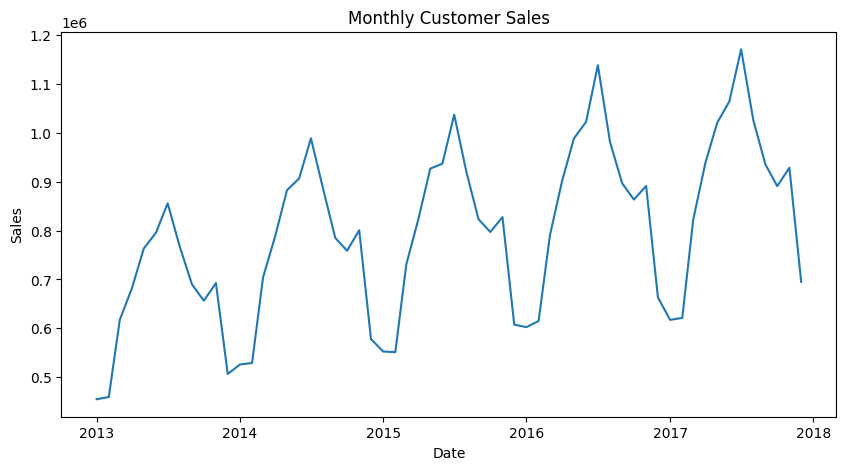

In [100]:
plt.figure(figsize=(10,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

Since, Data is showing an incrreasing trend over time as we can see here mostly.We need to make data stationary to improve the training phase of the learning models. So we will take difference of sales columns.

In [101]:
monthly_sales['sales_diff']=monthly_sales['sales'].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


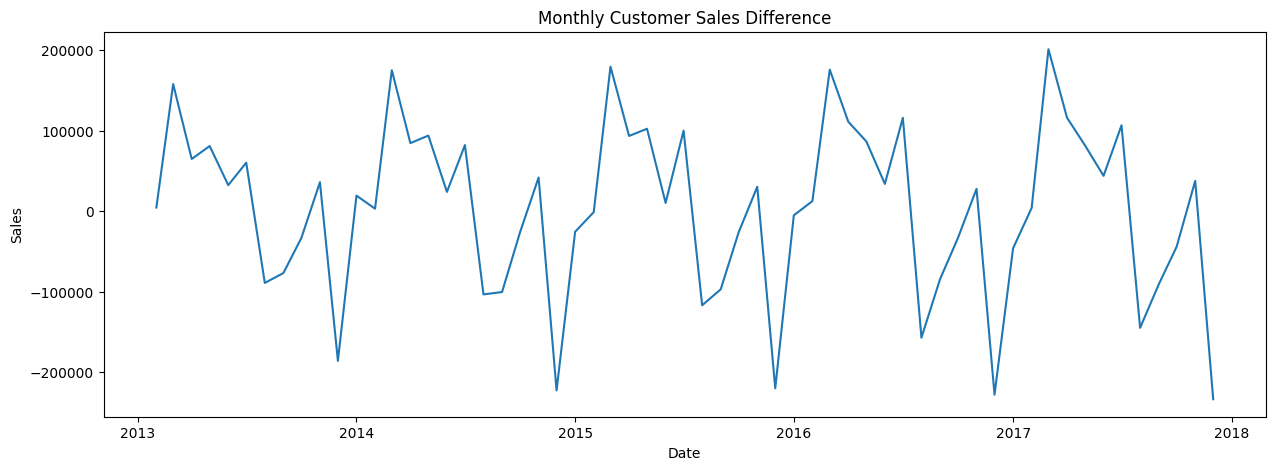

In [102]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales Difference')
plt.show()

Dropping off sales and date as we need only monthly_sales to train the model

In [103]:
supervised_data=monthly_sales.drop(['sales','date'],axis=1)

In [104]:
supervised_data.head(10)

,sales_diff
1,4513.0
2,157965.0
3,64892.0
4,80968.0
5,32355.0
6,60325.0
7,-89161.0
8,-76854.0
9,-33320.0
10,36056.0


Preparing the supervised data(previous 12 months sales acts as input feature and next 12 months sales act as output feature).

In [105]:
for i in range(1,13):
  col_name='month_'+str(i)
  supervised_data[col_name]=supervised_data['sales_diff'].shift(i)
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Split the data into Train and Test.

In [106]:
train_data=supervised_data[:-12]
test_data=supervised_data[-12:]
print("Train Data Shape",train_data.shape)
print("Test Data Shape",test_data.shape)

Train Data Shape (35, 13)
Test Data Shape (12, 13)


Scaling the feature from -1 to 1

In [107]:
scaler =MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In the supervised frame the first column always represents the output i.e. for x_train, y_test

In [108]:
X_train,y_train=train_data[:,1:],train_data[:,0:1]
X_test,y_test=test_data[:,1:],test_data[:,0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
print("X_train Shape",X_train.shape)
print("y_train Shape",y_train.shape)
print("X_test Shape",X_test.shape)
print("y_test Shape",y_test.shape)

X_train Shape (35, 12)
y_train Shape (35,)
X_test Shape (12, 12)
y_test Shape (12,)


Make prediction data frame to merge the predicted sales prices of all trained algorithm.

In [109]:
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

In [110]:
act_sales=monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


Preprocessing Ends.Now, to create **Linear Regression Model**, and predicted output.

In [111]:
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)
lr_pre=lr_model.predict(X_test)

In [112]:
lr_pre=lr_pre.reshape(-1,1)
#This is a set matrix- contains the input features of the test data, and also the predicted output
lr_pre_test_set=np.concatenate([lr_pre,X_test],axis=1)
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set)

In [113]:
result_list=[]
for index in range(0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+act_sales[index])
lr_pre_series=pd.Series(result_list,name='Linear Prediction')
predict_df=predict_df.merge(lr_pre_series,left_index=True,right_index=True)

In [117]:
print(predict_df)

         date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


Now, comparing the predicted values with the actual values to test the accuracy of our prediction.

In [118]:
lr_mse=np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:]))
lr_mae=mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
lr_r2=r2_score(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
print("Linear Regression Model MSE",lr_mse)
print("Linear Regression Model MAE",lr_mae)
print("Linear Regression Model R2",lr_r2)

Linear Regression Model MSE 16221.272385416869
Linear Regression Model MAE 12433.184266490736
Linear Regression Model R2 0.9906152516380969


Visualization of predicted sales against actual sales.

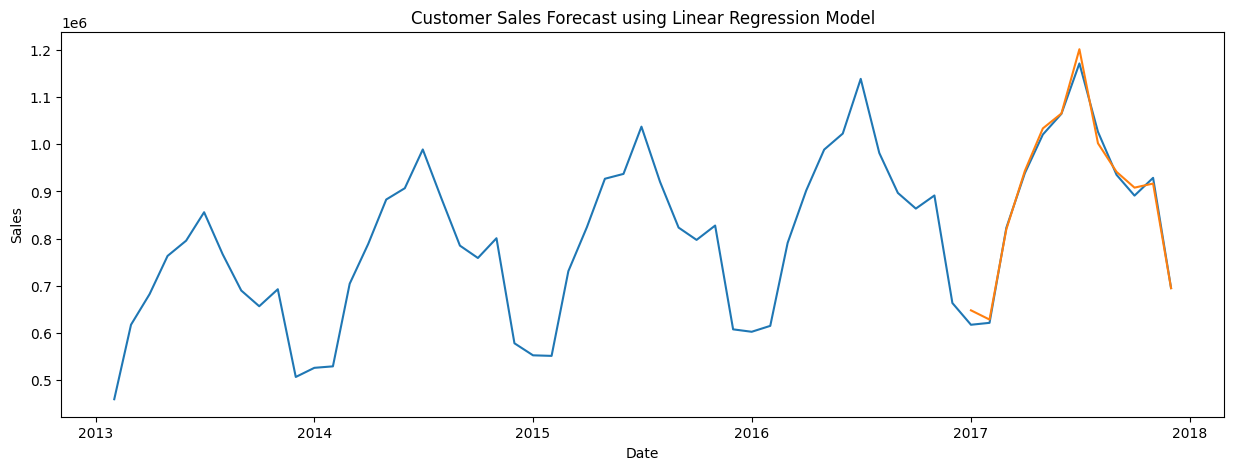

In [114]:
plt.figure(figsize=(15,5))
#Actual sales
plt.plot(monthly_sales['date'],monthly_sales['sales'])
#Predicted sales
plt.plot(predict_df['date'],predict_df['Linear Prediction'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Customer Sales Forecast using Linear Regression Model')
plt.show()